In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/Loan_eligibility

/content/drive/MyDrive/Loan_eligibility


# Data audit
This section performs a comprehensive data audit of both the training and test datasets used for the Loan Eligibility Prediction project. Using a custom audit_dataset() function, we extracted key insights including dataset shape, missing values per column, duplicate row counts, data types, and value distributions for categorical features. Additionally, we analyzed summary statistics for all numerical variables. This audit helps establish a clear understanding of data quality, identify preprocessing needs (such as handling nulls or skewed distributions), and surface any potential data imbalance that could impact model fairness or performance. These insights guided the data cleaning and modeling steps that followed.


In [8]:
import pandas as pd

# Load the files (adjust path if running locally)
train = pd.read_csv("train_u6lujuX_CVtuZ9i.csv")
test = pd.read_csv("test_Y3wMUE5_7gLdaTN.csv")

# Function to summarize datasets
def audit_dataset(df, name="Dataset"):
    print(f"\n📊 Audit Summary for: {name}")
    print(f"→ Shape: {df.shape}")
    print("→ Missing values per column:")
    print(df.isnull().sum())
    print(f"→ Duplicate rows: {df.duplicated().sum()}")
    print("\n→ Data Types:")
    print(df.dtypes)
    print("\n→ Categorical Value Counts:")
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        print(f"\n{col}:\n{df[col].value_counts(dropna=False)}")
    print("\n→ Numerical Stats:")
    print(df.describe())

# Run audit
audit_dataset(train, "Training Data")
audit_dataset(test, "Test Data")


📊 Audit Summary for: Training Data
→ Shape: (614, 13)
→ Missing values per column:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
→ Duplicate rows: 0

→ Data Types:
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

→ Categorical Value Counts:

Loan_ID:
Loan_ID
LP002990    1
LP001002    1
LP001003    1
LP001005    1
LP001006    1
           ..
LP001024    1
LP001020    1
LP0010

# Data Preprocessing and Encoding

To prepare the data for machine learning, this section applies a comprehensive preprocessing pipeline. It begins by handling missing values in both categorical and numerical columns—using the mode for categorical features (e.g., Gender, Married) and the median for numerical features (e.g., LoanAmount, Credit_History). For the Dependents column, string values like '3+' are replaced with 3 and cast to integers for consistency. All categorical features are then transformed into numerical format using Label Encoding, ensuring compatibility with scikit-learn and XGBoost models. Lastly, the Loan_Status target variable is encoded as binary (1 for approved, 0 for not approved) only in the training set. This preprocessing step ensures that the dataset is clean, consistent, and fully numeric—ready for training and evaluation.

In [10]:
from sklearn.preprocessing import LabelEncoder

def preprocess(df, is_train=True):
    df = df.copy()

    # Fill categorical NaNs with modes
    for col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
        mode_val = df[col].mode()[0]
        df.loc[:, col] = df[col].fillna(mode_val)

    # Fix '3+' in Dependents and convert to int
    df['Dependents'] = df['Dependents'].replace('3+', '3').astype(int)

    # Fill numerical NaNs with median
    for col in ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']:
        median_val = df[col].median()
        df.loc[:, col] = df[col].fillna(median_val)

    # Label Encoding for categoricals
    label_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
    for col in label_cols:
        df[col] = LabelEncoder().fit_transform(df[col])

    # Encode target column if training set
    if is_train:
        df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

    return df

# Re-run preprocessing
train_clean = preprocess(train, is_train=True)
test_clean = preprocess(test, is_train=False)

print(train_clean.isnull().sum())
print(test_clean.isnull().sum())
train_clean.head()

# Exploratory Data Analysis (EDA)

This section visualizes patterns, distributions, and relationships in the dataset to derive insights that can guide model building. It begins with a count plot of the target variable (Loan_Status) to assess class distribution. Next, it examines the influence of key categorical features (e.g., Gender, Married, Education) on loan approval rates by comparing approval counts across categories. For numerical variables, both histograms with KDEs and box plots are used to understand their distribution and how they relate to loan approval. Finally, a correlation heatmap reveals linear relationships among numerical features, highlighting which variables may be strong predictors of loan status. These visualizations help uncover class imbalance, income disparities, and feature relationships essential for informed model development.

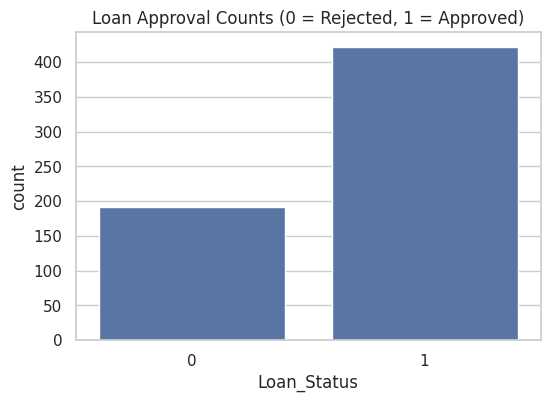

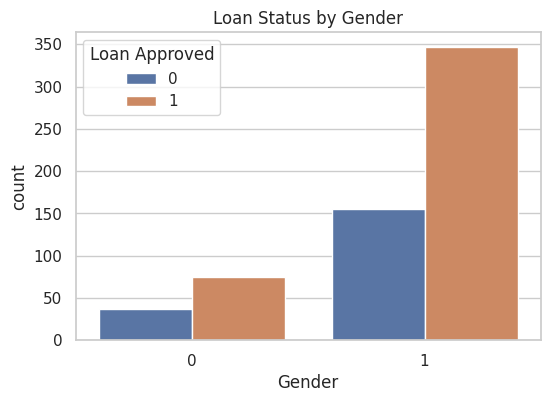

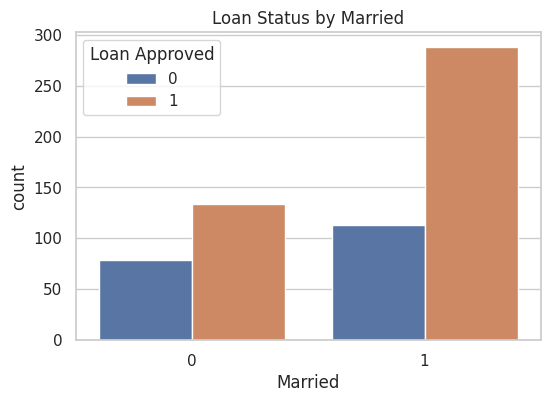

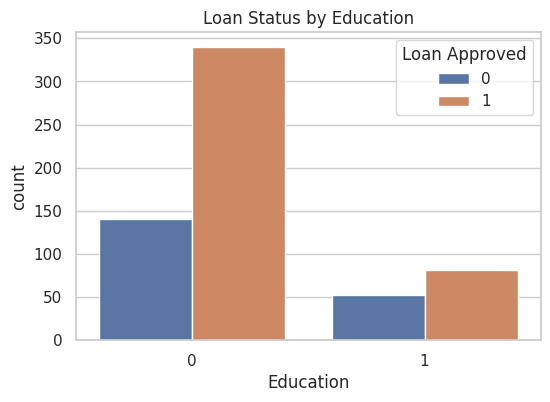

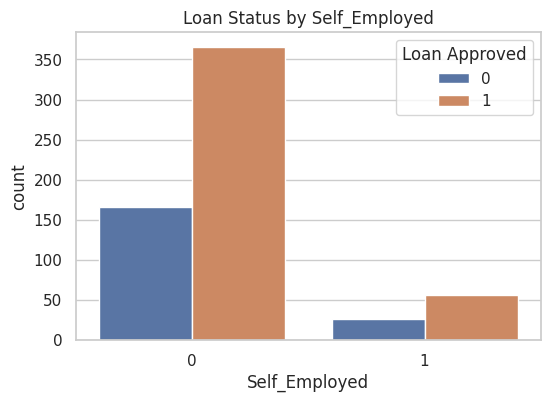

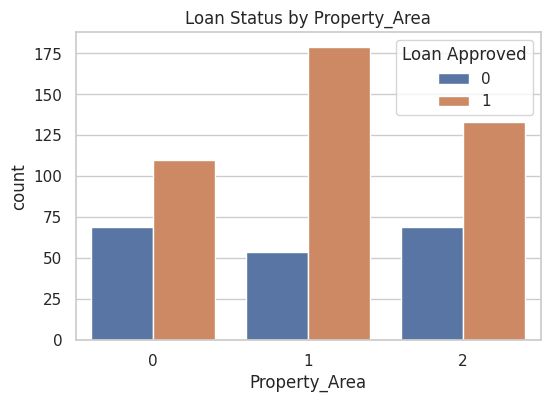

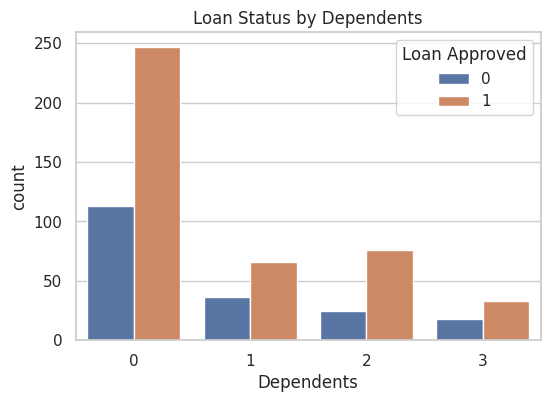

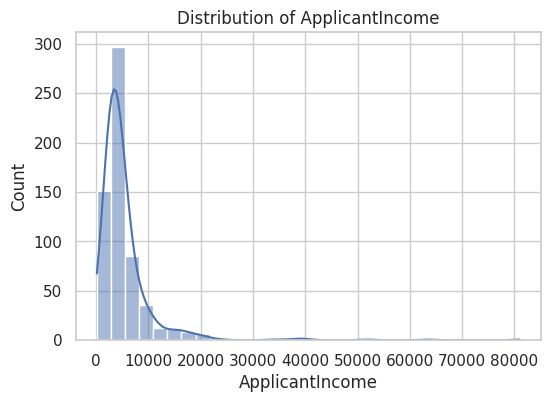

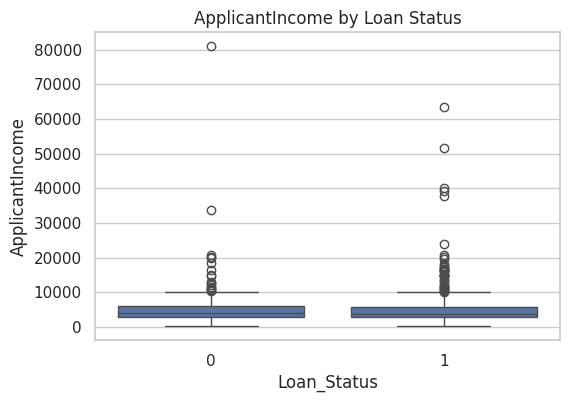

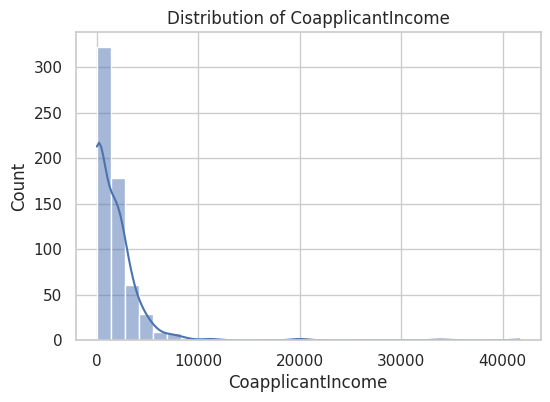

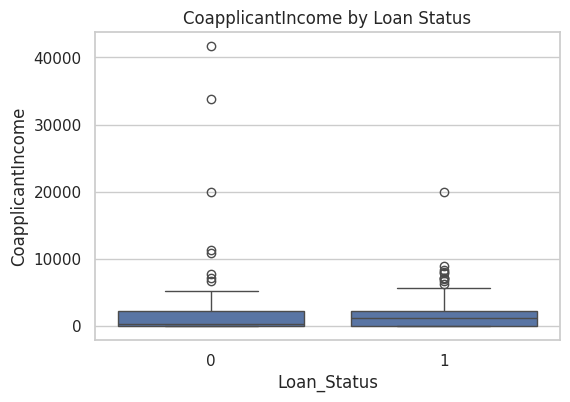

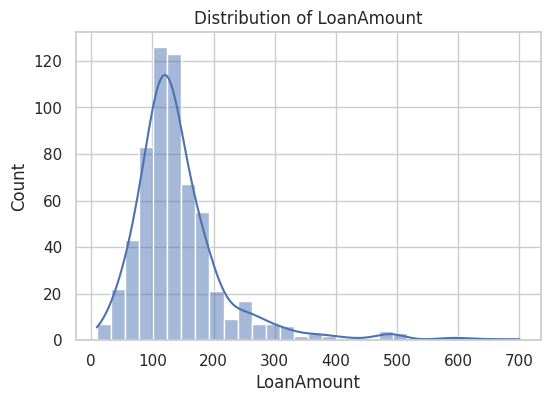

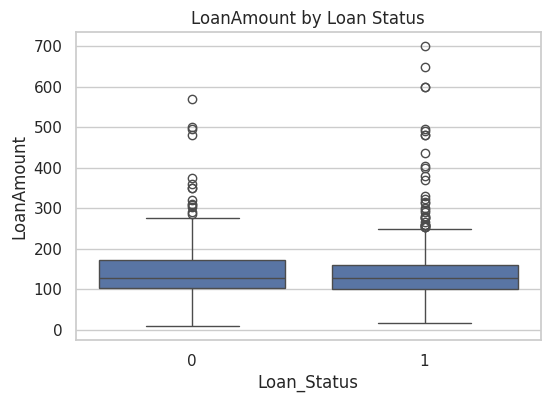

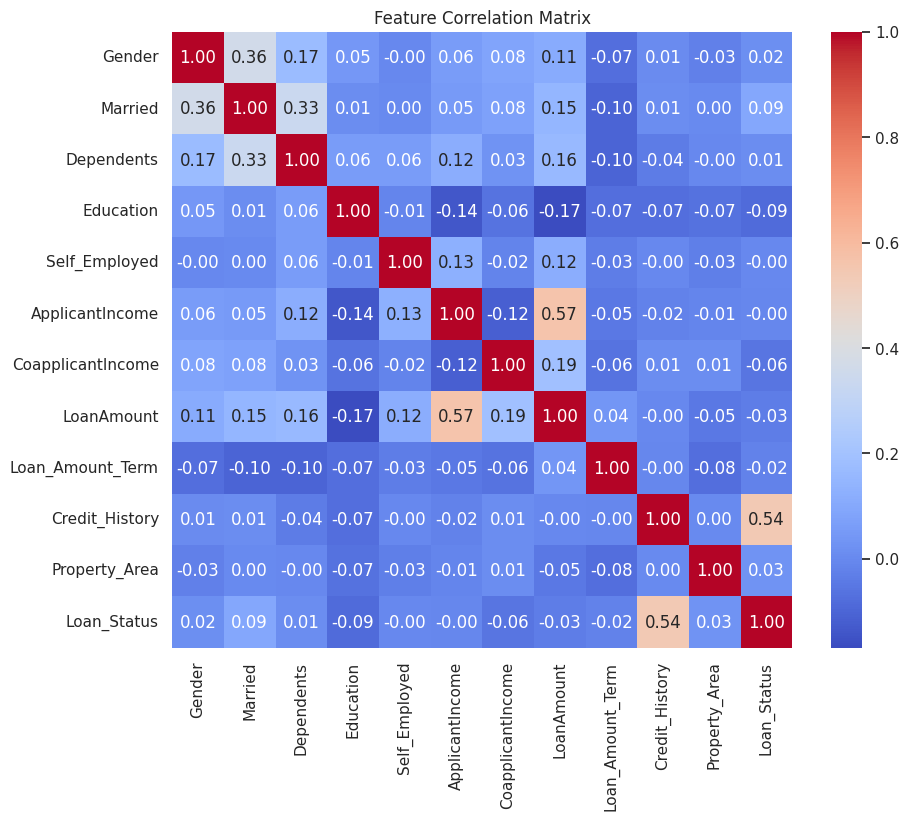

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# 1. Target variable distributions
plt.figure(figsize=(6, 4))
sns.countplot(x='Loan_Status', data=train_clean)
plt.title("Loan Approval Counts (0 = Rejected, 1 = Approved)")
plt.show()

# 2. Categorical features vs Loan Status
cat_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents']
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='Loan_Status', data=train_clean)
    plt.title(f'Loan Status by {col}')
    plt.legend(title='Loan Approved')
    plt.show()

# 3. Numerical distributions
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(train_clean[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Loan_Status', y=col, data=train_clean)
    plt.title(f'{col} by Loan Status')
    plt.show()

# 4. Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_clean.drop(columns='Loan_ID').corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Model Training: Random Forest Classifier

In this step, a Random Forest Classifier is trained to predict loan approval status. The dataset is split into training and validation sets using stratified sampling to preserve class distribution. The model is then trained on the training set and evaluated on the validation set using key classification metrics: accuracy, precision, recall, and F1-score. These metrics help assess overall performance, especially how well the model balances false positives and false negatives. A confusion matrix is also plotted to visualize the true vs. predicted classifications, which aids in identifying any model bias or imbalance. This baseline model serves as a benchmark for further optimization and comparison with more advanced algorithms like XGBoost.

📊 Evaluation Metrics:
Accuracy: 0.8292682926829268
Precision: 0.8478260869565217
Recall: 0.9176470588235294
F1 Score: 0.8813559322033898

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.63      0.70        38
           1       0.85      0.92      0.88        85

    accuracy                           0.83       123
   macro avg       0.81      0.77      0.79       123
weighted avg       0.83      0.83      0.82       123



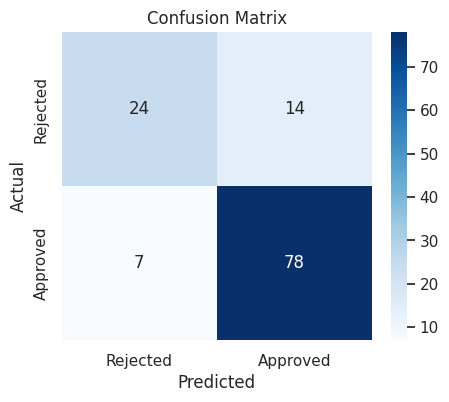

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split data (stratify to maintain class balance)
X = train_clean.drop(columns=['Loan_ID', 'Loan_Status'])
y = train_clean['Loan_Status']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Training Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

# Evaluation metrics
print("📊 Evaluation Metrics:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Confusion matrix plot
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Model Comparison: Random Forest vs. XGBoost

To identify the most effective algorithm for loan approval prediction, both Random Forest and XGBoost classifiers were trained and evaluated on the same training and validation sets. Each model was assessed using core evaluation metrics: accuracy, precision, recall, and F1-score—giving a well-rounded view of their performance on both approved and rejected cases. A helper function was used to streamline the reporting of these metrics. This comparison provides clarity on which model better balances bias and variance, and informs the selection of the final model for deployment. Typically, XGBoost performs better on structured/tabular data, but this side-by-side evaluation validates that with real results on our dataset.

In [14]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings
warnings.filterwarnings("ignore")  # to suppress xgboost warnings

# Define and train both models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Predict
rf_pred = rf_model.predict(X_val)
xgb_pred = xgb_model.predict(X_val)

# Function to print metrics
def evaluate_model(name, y_true, y_pred):
    print(f"\n📊 {name} Results")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Evaluate both
evaluate_model("Random Forest", y_val, rf_pred)
evaluate_model("XGBoost", y_val, xgb_pred)


📊 Random Forest Results
Accuracy: 0.8292682926829268
Precision: 0.8478260869565217
Recall: 0.9176470588235294
F1 Score: 0.8813559322033898

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.63      0.70        38
           1       0.85      0.92      0.88        85

    accuracy                           0.83       123
   macro avg       0.81      0.77      0.79       123
weighted avg       0.83      0.83      0.82       123


📊 XGBoost Results
Accuracy: 0.8292682926829268
Precision: 0.872093023255814
Recall: 0.8823529411764706
F1 Score: 0.8771929824561403

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.71      0.72        38
           1       0.87      0.88      0.88        85

    accuracy                           0.83       123
   macro avg       0.80      0.80      0.80       123
weighted avg       0.83      0.83      0.83       123



# XGBoost with Class Imbalance Handling and Threshold Tuning

Following our model comparison, XGBoost was chosen as the final model due to its superior balance of precision, recall, and overall F1-score. To further enhance its performance, we applied several advanced techniques:
	•	Class Imbalance Handling: The scale_pos_weight parameter was calculated from the training data to ensure that the model fairly considers both approved and rejected loan cases.
	•	Hyperparameter Tuning: A grid search with cross-validation was used to identify the best combination of hyperparameters including tree depth, learning rate, and column/sample subsampling.
	•	Threshold Tuning: Instead of relying on the default 0.5 cutoff, we applied a custom threshold of 0.52 to better balance false positives and false negatives. This tuning aimed to retain approval sensitivity without overwhelming false approvals.

A confusion matrix and classification report validated the performance of this tuned model, making it ready for deployment.

Fitting 3 folds for each of 72 candidates, totalling 216 fits

🚀 Best XGBoost Parameters:
{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'scale_pos_weight': np.float64(0.456973293768546), 'subsample': 0.8}

📌 Using Threshold = 0.52

Confusion Matrix:
[[28 10]
 [17 68]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.74      0.67        38
           1       0.87      0.80      0.83        85

    accuracy                           0.78       123
   macro avg       0.75      0.77      0.75       123
weighted avg       0.79      0.78      0.79       123



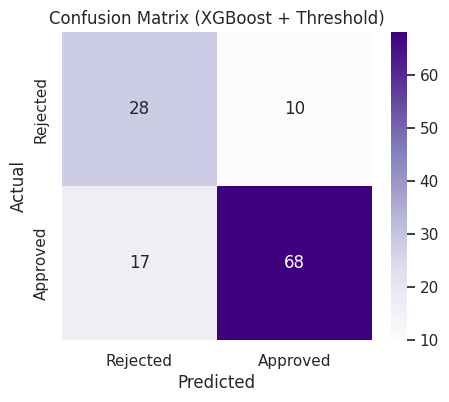

In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Split the data
X = train_clean.drop(columns=['Loan_ID', 'Loan_Status'])
y = train_clean['Loan_Status']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 2: Handle class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Step 3: Define XGBoost model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Step 4: Parameter grid including class weight
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'scale_pos_weight': [scale_pos_weight]
}

# Step 5: Grid Search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_

# Step 6: Predict probabilities instead of labels
y_proba = best_xgb.predict_proba(X_val)[:, 1]

# Step 7: Apply custom threshold
best_threshold = 0.52
y_pred = (y_proba >= best_threshold).astype(int)

# Step 8: Evaluation
print("\n🚀 Best XGBoost Parameters:")
print(grid_search.best_params_)

print(f"\n📌 Using Threshold = {best_threshold}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Step 9: Confusion Matrix Plot
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Purples',
            xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost + Threshold)")
plt.show()

# Saving the Final XGBoost Model and Predictions

After identifying the best-performing XGBoost model through hyperparameter tuning and threshold optimization, the following final steps were carried out:
	•	Model Saving: The trained model was serialized using joblib for future reuse without retraining.
	•	Threshold Logging: The optimal decision threshold (0.52) used during prediction was saved in a text file for reproducibility.
	•	Validation Prediction Archiving: The validation predictions—including predicted probabilities and labels—were saved alongside the actual labels. This allows post-hoc analysis of prediction correctness.
	•	Performance Check: A quick verification was done to confirm how many model predictions matched the actual labels, with the resulting accuracy printed before saving.

These artifacts (xgboost_loan_model.pkl, best_threshold.txt, and val_predictions.csv) can be uploaded to platforms like Kaggle for demonstration or sharing.

In [32]:
import joblib
# 8. Save model
joblib.dump(model, "xgboost_loan_model.pkl")

# 9. Save best threshold
threshold = 0.52
with open("best_threshold.txt", "w") as f:
    f.write(f"Best threshold used: {threshold}\n")
# 10. Save validation predictions
val_pred_proba = model.predict_proba(X_val)[:, 1]
val_pred_label = (val_pred_proba >= threshold).astype(int)

# Compare predictions with actual labels
matches = (val_pred_label == y_val).sum()
total = len(y_val)
accuracy = matches / total

print(f"✅ Matched Predictions: {matches} out of {total}")
print(f"🔍 Accuracy before saving: {accuracy:.2%}")

# Create dataframe to save
val_df = X_val.copy()
val_df['Actual'] = y_val.values
val_df['Predicted_Prob'] = val_pred_proba
val_df['Predicted_Label'] = val_pred_label

# 11. Save the results
val_df.to_csv("val_predictions.csv", index=False)

✅ Matched Predictions: 102 out of 123
🔍 Accuracy before saving: 82.93%


In [36]:
import pandas as pd
import joblib
import sys

# --- Load model and threshold safely ---
try:
    model = joblib.load("xgboost_loan_model.pkl")
except FileNotFoundError:
    print("❌ Model file not found. Please ensure 'xgboost_loan_model.pkl' is in the directory.")
    sys.exit(1)

try:
    with open("best_threshold.txt", "r") as f:
        threshold = float(f.read().strip().split(":")[-1])
except Exception:
    print("❌ Error reading threshold file. Please ensure 'best_threshold.txt' is valid.")
    sys.exit(1)

# --- Input function with validation ---
def get_input(prompt, options=None, is_numeric=False):
    while True:
        user_input = input(f"{prompt} {'('+ '/'.join(options) + ')' if options else ''}: ").strip()
        user_input_lower = user_input.lower()

        # Handle numeric input
        if is_numeric:
            try:
                return float(user_input)
            except ValueError:
                print("❗ Please enter a valid number.")
                continue

        # Handle categorical input
        if options:
            # Normalize options and user input for comparison
            options_lower = [opt.lower() for opt in options]
            if user_input_lower in options_lower:
                return options[options_lower.index(user_input_lower)]
            else:
                print(f"❗ Invalid input. Choose from {options}.")
        else:
            return user_input
# --- Collect user inputs ---
print("\n📋 Please provide the following loan application details:\n")

data = {
    'Gender': get_input("Gender", ['Male', 'Female']),
    'Married': get_input("Married", ['Yes', 'No']),
    'Dependents': get_input("Number of Dependents", ['0', '1', '2', '3+']),
    'Education': get_input("Education", ['Graduate', 'Not Graduate']),
    'Self_Employed': get_input("Self Employed", ['Yes', 'No']),
    'ApplicantIncome': get_input("Applicant Income (number only)", is_numeric=True),
    'CoapplicantIncome': get_input("Coapplicant Income (number only)", is_numeric=True),
    'LoanAmount': get_input("Loan Amount (in thousands)", is_numeric=True),

    # ✅ Keep this version with restricted options
    'Loan_Amount_Term': float(get_input(
        "Loan Term in months (360 = 30 yrs, 180 = 15 yrs, 120 = 10 yrs, 60 = 5 yrs)",
        ['360', '180', '120', '60']
    )),

    'Credit_History': get_input("Credit History (1 for Good, 0 for Bad)", ['1', '0']),
    'Property_Area': get_input("Property Area", ['Urban', 'Semiurban', 'Rural'])
}

# --- Preprocess user input ---
def preprocess_input(df):
    df = df.copy()
    df['Dependents'] = df['Dependents'].replace('3+', '3').astype(int)

    label_map = {
        'Gender': {'Male': 1, 'Female': 0},
        'Married': {'Yes': 1, 'No': 0},
        'Education': {'Graduate': 1, 'Not Graduate': 0},
        'Self_Employed': {'Yes': 1, 'No': 0},
        'Property_Area': {'Urban': 2, 'Semiurban': 1, 'Rural': 0}
    }

    for col, mapping in label_map.items():
        df[col] = df[col].map(mapping)

    return df

# --- Prediction ---
new_df = pd.DataFrame([data])
processed_input = preprocess_input(new_df)
probability = model.predict_proba(processed_input)[0][1]
prediction = int(probability >= threshold)

# --- Output ---
print(f"\n🧮 Predicted Approval Probability: {probability:.2%}")
print(f"✅ Loan Status Prediction: {'Approved ✅' if prediction == 1 else 'Rejected ❌'}")


📋 Please provide the following loan application details:

Gender (Male/Female): male
Married (Yes/No): yes
Number of Dependents (0/1/2/3+): 2
Education (Graduate/Not Graduate): not graduate
Self Employed (Yes/No): no
Applicant Income (number only) : 100
Coapplicant Income (number only) : 20000
Loan Amount (in thousands) : 30000000000
Loan Term in months (360 = 30 yrs, 180 = 15 yrs, 120 = 10 yrs, 60 = 5 yrs) (360/180/120/60): 60
Credit History (1 for Good, 0 for Bad) (1/0): 0
Property Area (Urban/Semiurban/Rural): urban

🧮 Predicted Approval Probability: 43.00%
✅ Loan Status Prediction: Rejected ❌
